/Users/boseong/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/boseong/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


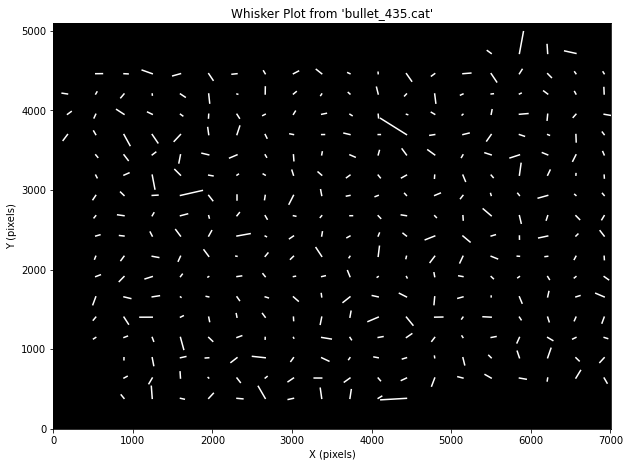

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy
import scipy.fft as fft
import astropy.constants as const
import astropy.units as u
from astropy.io import fits
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel
from astropy.cosmology import LambdaCDM
from photutils.segmentation import detect_threshold
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceCatalog
from scipy.interpolate import interp2d
from scipy.optimize import curve_fit
from math import pi
import csv

#-----Loading data
cat = ascii.read('bullet_435.cat')

#-----Morphological Properties
xcen = cat['X_IMAGE'].data     # max(xcen): 7011.474, min(xcen): 311.515
ycen = cat['Y_IMAGE'].data     # max(ycen): 4638.641, min(ycen): 311.515
phi = cat['THETA_IMAGE'].data

xmin = cat['XMIN_IMAGE'].data
xmax = cat['XMAX_IMAGE'].data  
ymin = cat['YMIN_IMAGE'].data  # rms = fits.open('bullet_f435w_RMS.fits'), rms[0].shape : (5100, 7013)
ymax = cat['YMAX_IMAGE'].data  # min(xmin): 264, max(xmax): 7013, min(ymin):311, max(ymax):4643
                                       
a = cat['A_IMAGE'].data        # Profile RMS along major axis 라는데 확실히 맞는지는 모르겠다.
b = cat['B_IMAGE'].data 

#-----Make image               ##### !!I have a question!! ##### 이미지는 catalog로부터 못 만드는 것 같은데 그럼 이미지는 어떻게 만드나? drz_sci랑 RMS 모두 정상적으로 안나오는데..?
image = np.zeros((5100,7013))

#-----gamma, gamma1, gamma2
r = (a-b) / (a+b)
r1 = r * np.cos(2*phi)
r2 = r * np.sin(2*phi)
#r_cos_phi = r * np.cos(phi)
#r_sin_phi = r * np.sin(phi)

#-----Whisker Plot

r1_mean_list = np.array([])
r2_mean_list = np.array([])

length_r = np.array([])

loc_start = np.empty((0,2))
loc_end = np.empty((0,2))

for i in range(20):
    for j in range(20):
        ind = np.where( (255*i<ycen) & (ycen<255*(i+1)) & (350*j<xcen) & (xcen<350*(j+1)) )     # 20by20 각 셀의 indexing
        # 현재 cat의 number는 4474개

        r1_mean = 1e3*np.mean(r1[ind])                                                              # 각 셀에서의 gamma1과 gamma2의 평균(대표로 쓸 값)
        r2_mean = 1e3*np.mean(r2[ind])
        r1_mean_list = np.append(r1_mean_list, r1_mean)
        r2_mean_list = np.append(r2_mean_list, r2_mean)

        center = np.array([355*j+355/2, 255*i+255/2], dtype='float64').reshape(1,2)             # 20by20의 각 셀의 중심 좌표
        loc_start = np.append(loc_start, center, axis=0)
        
        stick_end = np.array([center[0][0]+r1_mean, center[0][1]+r2_mean]).reshape(1,2)
        loc_end = np.append(loc_end, stick_end, axis=0)                                               # 20by20의 각 셀에 해당하는 whisker plot의 끝 점 좌표

background = np.zeros((5100,7013))

fig = plt.figure(figsize=(10,10))
plt.imshow(background, cmap='gray', origin = 'lower')
plt.plot([loc_start[:,0],loc_end[:,0]], [loc_start[:,1],loc_end[:,1]], color='w')
plt.title("Whisker Plot from 'bullet_435.cat'")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.show()

#-----mass distribution map(=kapp map)

#####r1_intep = interp2d(loc_start[:,0], loc_end[:,0], r1_mean_list, kind='cubic') 이게 아니지.. 2차원 시작점의 좌표가 있어야하니까.
#####r2_intep = interp2d(loc_start[:,1], loc_end[:,1], r2_mean_list, kind='cubic')



In [27]:
print(len(loc_start[:,0]))
print(len(loc_start[:,1]))
print(len(r1_mean_list))

print(len(loc_end[:,0]))
#print(loc_end[:,1])

import math

ind = np.where(np.isnan(r2_mean_list))
r2_mean_list[ind]=0
print(r2_mean_list)

400
400
400
400
[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan  4.29239111e+01  1.51024249e+02
 -1.04366283e+01  6.26816658e+01 -6.61956032e+00  1.50121762e+02
 -1.43415764e+01  1.26847810e+02  1.08816892e+02  2.68280795e+01
 -1.88213837e+01             nan             nan             nan
             nan             nan             nan             nan
             nan             nan  2.13822075e+01 -7.09514328e+01
  7.73766061e+01  6.41761224e+00 -5.47564893e+01  1.90572925e+01
 -4.61446590e+01  2.41344979e-01 -5.06730705e+01 -3.35352316e+01
 -2.98363696e+01 -1.01201467e+02  1.61896695e+01  4.35135461e+01
 -1.45878905e+01 -3.68841541e+01  9.48537892e+01 -6.36937437e+01
         

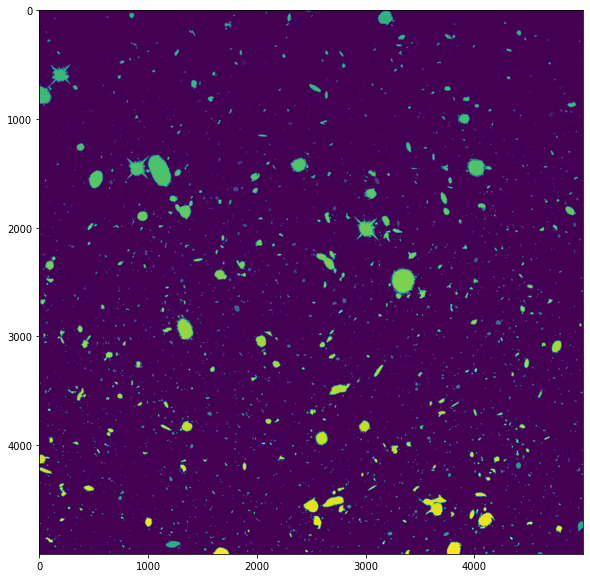

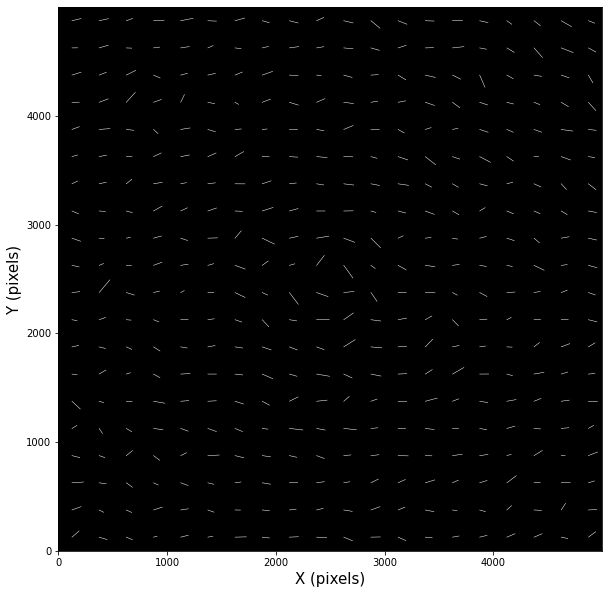

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy.fft as fft
import astropy.constants as const
import astropy.units as u #####이건 내가 효선이 코드 218행의 H0의 단위 제대로 하기 위해 추가한 것
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.cosmology import LambdaCDM
from photutils.segmentation import detect_threshold
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceCatalog
from scipy.interpolate import interp2d
from scipy.optimize import curve_fit
from math import pi

#----- Load Data
fitsdata = 'distorted_field.fits'
image = fits.open(fitsdata)
data = image[0].data


#----- Detect Source
threshold = detect_threshold(data, nsigma=2.)
sigma = 1.2
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold, npixels=5, kernel=kernel)
segm_deblend = deblend_sources(data, segm, npixels=5, kernel= kernel, 
                                nlevels=32, contrast=0.001)
sources = segm_deblend.data


#----- Detected Source Plot
plt.figure(figsize=(10,10))
plt.imshow(sources)


#----- Morphological Properties
cat = SourceCatalog(data, segm_deblend)
tbl = cat.to_table()

xcen = np.array(tbl['xcentroid'].data)
ycen = np.array(tbl['ycentroid'].data)
a = np.array(tbl['semimajor_sigma'].data)
b = np.array(tbl['semiminor_sigma'].data)
phi = np.array(tbl['orientation'].data) * pi / 180

e = (a-b)/(a+b)
e1 = e * np.cos(phi) #####사실 이건 e_x라고 해야한다. 수업 시간에 배운 e2랑은 다른 것이기 때문. 오로지 whisker plot을 그릴 때 20by20으로 만들어주기 위함이다. e의 정보를 다시 되살려야하므로.
e2 = e * np.sin(phi) #####사실 이건 e_y라고 해야한다. 수업 시간에 배운 e2랑은 다른 것이기 때문. 오로지 whisker plot을 그릴 때 20by20으로 만들어주기 위함이다. e의 정보를 다시 되살려야하므로.

real_e1 = e * np.cos(2*phi) #####이게 진짜 e1
real_e2 = e * np.sin(2*phi) #####이게 진짜 e2

#----- Whisker plot
background = np.zeros((5000, 5000))
start_loc = np.empty((0,2))           #np.empty((0,2))의 결과는 그냥 []이다. 어차피 추가할 목적으로 빈 어레이를 할당하는 것이기에 이렇게 첫 번째 원소에 0을 넣는 것이다. 우리는 아래로 원소를 추가해야 하니까 np.append를 쓸 때 2차원 행방향을 의미하는 axis=0을 써야한다.
end_loc = np.empty((0,2))             #np.zeros보다 np.empty를 쓰는 이유는 empty가 훨씬 빠르기 때문인 것 같다.
real_end_loc = np.empty((0,2))
e1_list = np.array([])
e2_list = np.array([])
#####phi_from_ex = np.array([])
#####phi_from_e1 = np.array([])
real_e1_list = np.array([])
real_e2_list = np.array([])
#####e_list = np.array([])

for i in range(20):
    for j in range(20):
        ind = np.where( (xcen>=i*250) & (xcen<(i+1)*250) & (ycen>=j*250) & (ycen<(j+1)*250) )
        e1_avg = 5*1e2*np.mean(e1[ind]) #? 왜 500을 곱하지? --> 아마 그냥 시각적인 크기를 키우려고?
        e2_avg = 5*1e2*np.mean(e2[ind])
        real_e1_avg = 5*1e2*np.mean(real_e1[ind])
        real_e2_avg = 5*1e2*np.mean(real_e2[ind])
        e1_list = np.append(e1_list, e1_avg)
        e2_list = np.append(e2_list, e2_avg)
        real_e1_list = np.append(real_e2_list, real_e1_avg)
        real_e2_list = np.append(real_e2_list, real_e2_avg)
        #####e_list = np.append(e_list, (e1_avg**2 + e2_avg**2)**(1/2))
        #####phi_from_ex =  np.append(phi_from_ex, np.arccos(e1_avg/e_list))
        #####phi_from_e1 =  np.append(phi_from_e1, (1/2)*np.arccos(real_e1_avg/e_list))
        center = np.array([[i*250+125, j*250+125]]) # 왜 []이걸 한 번이 아니라 두 번 감싸지? --> np.append 쓸 때 원래의 차원인 2차원 유지시켜주려면 추가하려는 array 또한 같은 차원인 2차원이어야 한다. 그래야지만 axis라는 파라미터 쓸 수 있다.
        start_loc = np.append(start_loc, center, axis=0)
        stick_end = np.array([[center[0,0]+e1_avg, center[0,1]+e2_avg]])
        #####stick_end = np.array([[center[0,0]+ e_list * np.cos(phi_from_ex) , center[0,1]+ e_list * np.sin(phi_from_ex)]])
        end_loc = np.append(end_loc, stick_end, axis=0)

fig = plt.figure(figsize=(10,10))
plt.imshow(background, cmap='gray', origin='lower') ##### 아, 이건 단순히 검은 바탕 만드려고 쓴거다. 아래 plot의 color='w'(즉, 하얀색)로 하여 검은 바탕에 흰 수염으로 그려지도록 함.
                                                    ##### imshow 빼려면 그냥 color = 'black'으로 하면 된다. 참고로 color 지정 안하면 색이 한 줄마다 다 다르게 나와서 정신없음.
plt.plot([start_loc[:,0], end_loc[:,0]], [start_loc[:,1], end_loc[:,1]], linewidth=0.5, color='w')
plt.xlabel("X (pixels)", size=15)
plt.ylabel("Y (pixels)", size=15)
plt.show()


#----- Mass Redconstruction # 아.. 원래의 이미지에서 100by100으로 만드는게 아니라 20by20으로 줄인 whisker plot에서 다시 100by100으로 키우는 것이다. interpolaiton을 이용하여.
##### 수정: 굳이 interpolation하지 않고 원 데이터 그대로 가져다 쓴다.
##### 효선이는 e1, e2를 써야하는 부분에서 e_x, e_y를 써서 틀렸다.
#f_e1 = interp2d(start_loc[:,0], start_loc[:,1], e1_list, kind='cubic') # 여기서 원래는 ramma1, ramma2 써야하는데 근사적으로 ramma1 = e1, ramma2 = e2라고 보고 있으므로,
#f_e2 = interp2d(start_loc[:,0], start_loc[:,1], e2_list, kind='cubic') # 그냥 e1, e2라고 적은 것이다.
f_e1 = interp2d(start_loc[:,0], start_loc[:,1], real_e1_list, kind='cubic') # 여기서 원래는 ramma1, ramma2 써야하는데 근사적으로 ramma1 = e1, ramma2 = e2라고 보고 있으므로,
f_e2 = interp2d(start_loc[:,0], start_loc[:,1], real_e2_list, kind='cubic') # 그냥 e1, e2라고 적은 것이다.

In [10]:
print(len(start_loc[:,0]), len(start_loc[:,1]), len(real_e1_list))
print(len(start_loc[:,0]), len(start_loc[:,1]), len(real_e1_list))

print(start_loc)
print()

400 400 400
400 400 400
[[ 125.  125.]
 [ 125.  375.]
 [ 125.  625.]
 [ 125.  875.]
 [ 125. 1125.]
 [ 125. 1375.]
 [ 125. 1625.]
 [ 125. 1875.]
 [ 125. 2125.]
 [ 125. 2375.]
 [ 125. 2625.]
 [ 125. 2875.]
 [ 125. 3125.]
 [ 125. 3375.]
 [ 125. 3625.]
 [ 125. 3875.]
 [ 125. 4125.]
 [ 125. 4375.]
 [ 125. 4625.]
 [ 125. 4875.]
 [ 375.  125.]
 [ 375.  375.]
 [ 375.  625.]
 [ 375.  875.]
 [ 375. 1125.]
 [ 375. 1375.]
 [ 375. 1625.]
 [ 375. 1875.]
 [ 375. 2125.]
 [ 375. 2375.]
 [ 375. 2625.]
 [ 375. 2875.]
 [ 375. 3125.]
 [ 375. 3375.]
 [ 375. 3625.]
 [ 375. 3875.]
 [ 375. 4125.]
 [ 375. 4375.]
 [ 375. 4625.]
 [ 375. 4875.]
 [ 625.  125.]
 [ 625.  375.]
 [ 625.  625.]
 [ 625.  875.]
 [ 625. 1125.]
 [ 625. 1375.]
 [ 625. 1625.]
 [ 625. 1875.]
 [ 625. 2125.]
 [ 625. 2375.]
 [ 625. 2625.]
 [ 625. 2875.]
 [ 625. 3125.]
 [ 625. 3375.]
 [ 625. 3625.]
 [ 625. 3875.]
 [ 625. 4125.]
 [ 625. 4375.]
 [ 625. 4625.]
 [ 625. 4875.]
 [ 875.  125.]
 [ 875.  375.]
 [ 875.  625.]
 [ 875.  875.]
 [ 875. 1125.]
 